## Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

## Load Data

In [4]:
# Load the synthetic dataset
df = pd.read_csv('../data/store_weekly_sales.csv')
store_metadata = pd.read_csv('../data/store_metadata.csv')

print(f"Loaded {len(df):,} store-week observations")
print(f"Loaded metadata for {len(store_metadata)} stores")
print(f"\nDataset date range: {df['week'].min()} to {df['week'].max()}")
print(f"\nFirst few rows:")
df.head()

Loaded 20,800 store-week observations
Loaded metadata for 200 stores

Dataset date range: 1 to 104

First few rows:


,store_id,week,week_date,treatment,post_treatment,sales
0,STORE_001,1,2023-01-01,0,0,79087.98
1,STORE_001,2,2023-01-08,0,0,81836.16
2,STORE_001,3,2023-01-15,0,0,96225.75
3,STORE_001,4,2023-01-22,0,0,92161.16
4,STORE_001,5,2023-01-29,0,0,117060.76


## Define Pre-Period

In [5]:
# Treatment starts at week 53, so pre-period is weeks 1-52
TREATMENT_START_WEEK = 53

# Filter to pre-period only
df_pre = df[df['week'] < TREATMENT_START_WEEK].copy()

print(f"Pre-period data: weeks {df_pre['week'].min()} to {df_pre['week'].max()}")
print(f"Total pre-period observations: {len(df_pre):,}")
print(f"Stores in pre-period: {df_pre['store_id'].nunique()}")

Pre-period data: weeks 1 to 52
Total pre-period observations: 10,400
Stores in pre-period: 200


## Compute Pre-Period Features by Store

In [6]:
def compute_sales_slope(store_data):
    """
    Fit linear regression: sales ~ week
    Returns the slope coefficient (change in sales per week)
    """
    X = store_data[['week']].values
    y = store_data['sales'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    return model.coef_[0]

# Compute features for each store
store_features = []

for store_id in df_pre['store_id'].unique():
    store_data = df_pre[df_pre['store_id'] == store_id]
    
    # Compute features
    slope = compute_sales_slope(store_data)
    avg_sales = store_data['sales'].mean()
    sales_std = store_data['sales'].std()
    cv = sales_std / avg_sales  # Coefficient of variation
    
    store_features.append({
        'store_id': store_id,
        'pre_slope': slope,
        'pre_avg_sales': avg_sales,
        'pre_sales_std': sales_std,
        'pre_cv': cv
    })

# Create DataFrame
features_df = pd.DataFrame(store_features)

# Merge with treatment assignment
features_df = features_df.merge(
    store_metadata[['store_id', 'treatment']], 
    on='store_id'
)

print(f"Computed features for {len(features_df)} stores")
print(f"\nFeature summary:")
features_df.head(10)

Computed features for 200 stores

Feature summary:


,store_id,pre_slope,pre_avg_sales,pre_sales_std,pre_cv,treatment
0,STORE_001,209.98,94213.64,16504.68,0.18,0
1,STORE_002,9.05,93900.29,15237.33,0.16,1
2,STORE_003,1063.64,127332.28,25332.16,0.20,1
3,STORE_004,695.20,114587.75,20382.88,0.18,0
4,STORE_005,7.20,114378.21,14108.65,0.12,0
5,STORE_006,220.87,81069.72,11115.74,0.14,0
6,STORE_007,566.03,98168.23,16843.89,0.17,0
7,STORE_008,57.62,117149.06,15158.75,0.13,0
8,STORE_009,574.46,93168.07,16552.58,0.18,0
9,STORE_010,844.27,146526.34,27417.40,0.19,1


## Summary Statistics

In [7]:
# Overall summary
print("Overall Pre-Period Feature Statistics:")
print("="*60)
print(features_df[['pre_slope', 'pre_avg_sales', 'pre_sales_std', 'pre_cv']].describe())

# By treatment group
print("\n\nPre-Period Features by Treatment Group:")
print("="*60)
summary_by_group = features_df.groupby('treatment')[[
    'pre_slope', 'pre_avg_sales', 'pre_sales_std', 'pre_cv'
]].agg(['mean', 'std', 'min', 'max'])

summary_by_group.index = summary_by_group.index.map({0: 'Control', 1: 'Treatment'})
print(summary_by_group)

Overall Pre-Period Feature Statistics:
       pre_slope  pre_avg_sales  pre_sales_std  pre_cv
count     200.00         200.00         200.00  200.00
mean      353.74      112665.63       18230.42    0.16
std       332.02       22569.87        4538.61    0.02
min      -508.03       64504.27        8105.11    0.12
25%       104.58       94906.60       15412.06    0.15
50%       343.20      112057.63       17747.94    0.16
75%       546.24      128277.27       21284.44    0.17
max      1448.72      178755.19       34107.77    0.23


Pre-Period Features by Treatment Group:
          pre_slope                         pre_avg_sales                      \
               mean    std     min      max          mean       std       min   
treatment                                                                       
Control      337.71  309.5 -508.03  1448.72     110441.53  22051.16  64504.27   
Treatment    401.83  391.5 -400.30  1378.70     119337.93  23013.15  67532.72   

                  

## Test for Balance Between Groups

Since treatment assignment was random, we expect no significant differences in pre-period characteristics.

In [8]:
# T-tests for each feature
features_to_test = ['pre_slope', 'pre_avg_sales', 'pre_sales_std', 'pre_cv']

print("Balance Tests (T-tests):")
print("="*70)
print(f"{'Feature':<20} {'Control Mean':>15} {'Treatment Mean':>15} {'p-value':>10}")
print("-"*70)

for feature in features_to_test:
    control = features_df[features_df['treatment'] == 0][feature]
    treatment = features_df[features_df['treatment'] == 1][feature]
    
    t_stat, p_value = stats.ttest_ind(control, treatment)
    
    print(f"{feature:<20} {control.mean():>15.2f} {treatment.mean():>15.2f} {p_value:>10.4f}")

print("\nNote: p-values > 0.05 indicate no significant difference (good for randomization)")

Balance Tests (T-tests):
Feature                 Control Mean  Treatment Mean    p-value
----------------------------------------------------------------------
pre_slope                     337.71          401.83     0.2379
pre_avg_sales              110441.53       119337.93     0.0154
pre_sales_std               17628.29        20036.80     0.0010
pre_cv                          0.16            0.17     0.0099

Note: p-values > 0.05 indicate no significant difference (good for randomization)


## Visualize Pre-Period Distributions

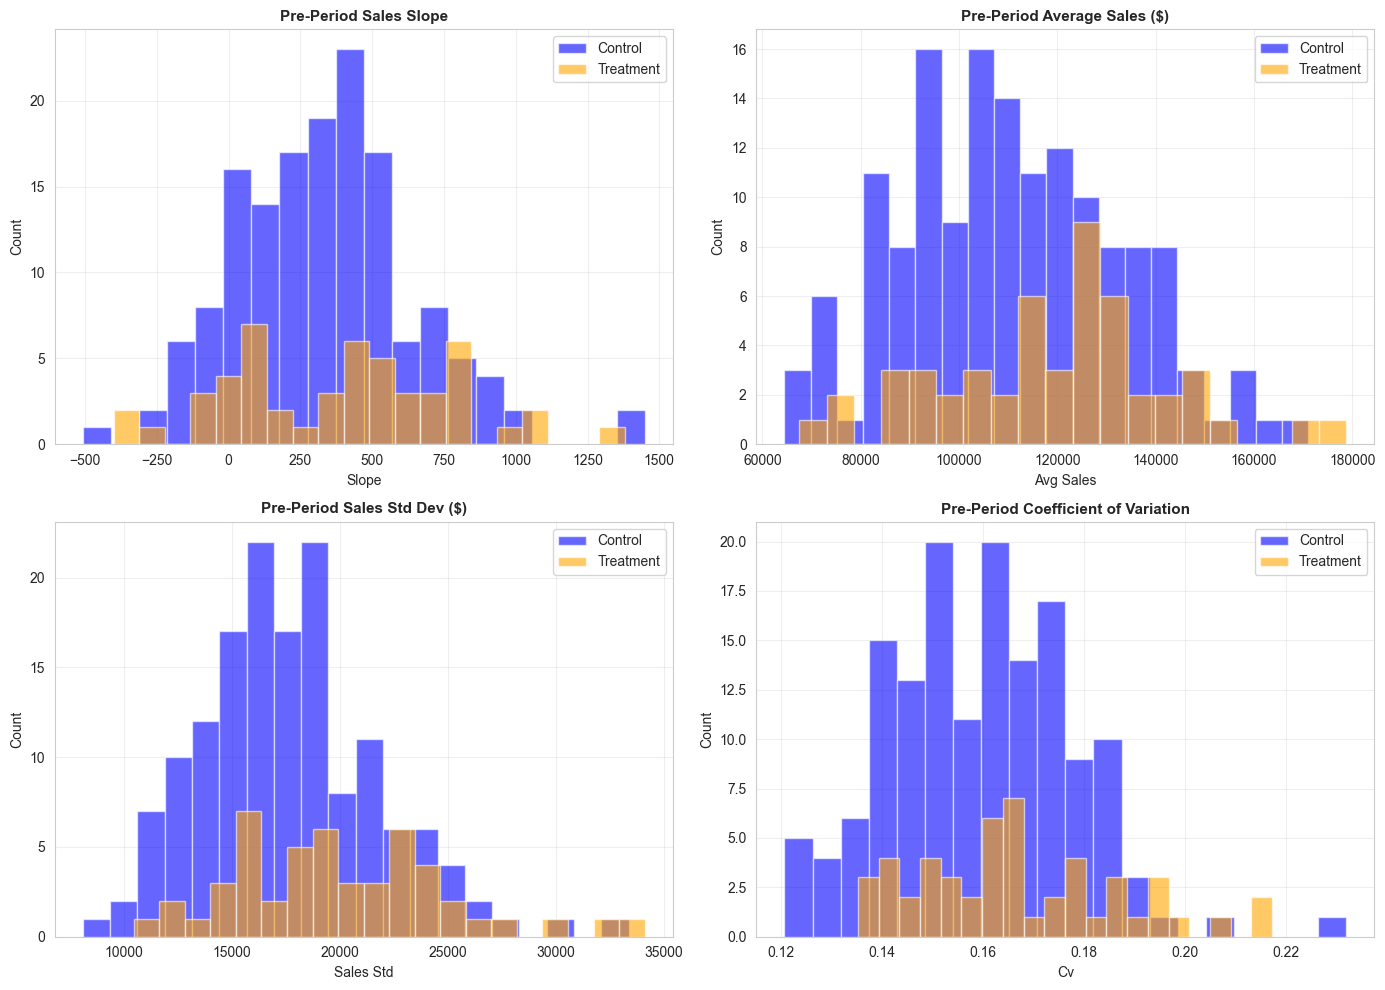

Distributions should be similar between groups if randomization was effective.


In [9]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

features_to_plot = [
    ('pre_slope', 'Pre-Period Sales Slope'),
    ('pre_avg_sales', 'Pre-Period Average Sales ($)'),
    ('pre_sales_std', 'Pre-Period Sales Std Dev ($)'),
    ('pre_cv', 'Pre-Period Coefficient of Variation')
]

for idx, (feature, title) in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Plot distributions
    control = features_df[features_df['treatment'] == 0][feature]
    treatment = features_df[features_df['treatment'] == 1][feature]
    
    ax.hist(control, alpha=0.6, bins=20, label='Control', color='blue')
    ax.hist(treatment, alpha=0.6, bins=20, label='Treatment', color='orange')
    
    ax.set_xlabel(feature.replace('pre_', '').replace('_', ' ').title(), fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Distributions should be similar between groups if randomization was effective.")

## Visualize Slope Distribution

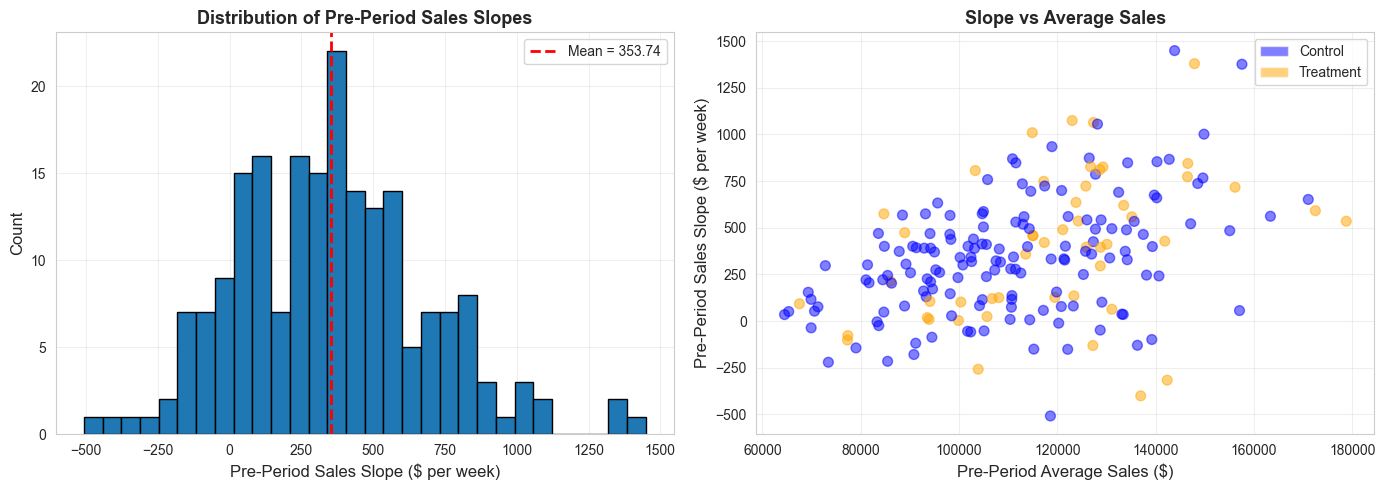

In [10]:
# More detailed look at the slope distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
ax = axes[0]
features_df['pre_slope'].hist(bins=30, ax=ax, edgecolor='black')
ax.axvline(features_df['pre_slope'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f"Mean = {features_df['pre_slope'].mean():.2f}")
ax.set_xlabel('Pre-Period Sales Slope ($ per week)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Pre-Period Sales Slopes', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Scatter: Slope vs Average Sales
ax = axes[1]
colors = features_df['treatment'].map({0: 'blue', 1: 'orange'})
ax.scatter(features_df['pre_avg_sales'], features_df['pre_slope'], 
           c=colors, alpha=0.5, s=50)
ax.set_xlabel('Pre-Period Average Sales ($)', fontsize=12)
ax.set_ylabel('Pre-Period Sales Slope ($ per week)', fontsize=12)
ax.set_title('Slope vs Average Sales', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', alpha=0.5, label='Control'),
    Patch(facecolor='orange', alpha=0.5, label='Treatment')
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

## Save Pre-Period Features

## Visualize Example Store Trajectories

Select stores with different pre-period growth patterns to illustrate heterogeneity.

In [12]:
# Select example stores with different growth patterns
features_sorted = features_df.sort_values('pre_slope')

# Get stores with different slope characteristics
declining_store = features_sorted.iloc[0]['store_id']  # Most declining
stable_store = features_sorted.iloc[len(features_sorted)//2]['store_id']  # Median slope
growing_store = features_sorted.iloc[-1]['store_id']  # Most growing

# Also get a few more examples for each category
n_examples = 3
declining_stores = features_sorted.head(n_examples)['store_id'].values
stable_stores = features_sorted.iloc[len(features_sorted)//2-1:len(features_sorted)//2+2]['store_id'].values
growing_stores = features_sorted.tail(n_examples)['store_id'].values

print("Example Stores by Growth Pattern:")
print("="*60)
print(f"\nMost Declining: {declining_store}")
print(f"  Slope: {features_sorted.iloc[0]['pre_slope']:.2f} $/week")
print(f"  Avg Sales: ${features_sorted.iloc[0]['pre_avg_sales']:,.0f}")

print(f"\nMost Stable: {stable_store}")
print(f"  Slope: {features_sorted.iloc[len(features_sorted)//2]['pre_slope']:.2f} $/week")
print(f"  Avg Sales: ${features_sorted.iloc[len(features_sorted)//2]['pre_avg_sales']:,.0f}")

print(f"\nMost Growing: {growing_store}")
print(f"  Slope: {features_sorted.iloc[-1]['pre_slope']:.2f} $/week")
print(f"  Avg Sales: ${features_sorted.iloc[-1]['pre_avg_sales']:,.0f}")

Example Stores by Growth Pattern:

Most Declining: STORE_138
  Slope: -508.03 $/week
  Avg Sales: $118,579

Most Stable: STORE_114
  Slope: 343.59 $/week
  Avg Sales: $111,079

Most Growing: STORE_175
  Slope: 1448.72 $/week
  Avg Sales: $143,843


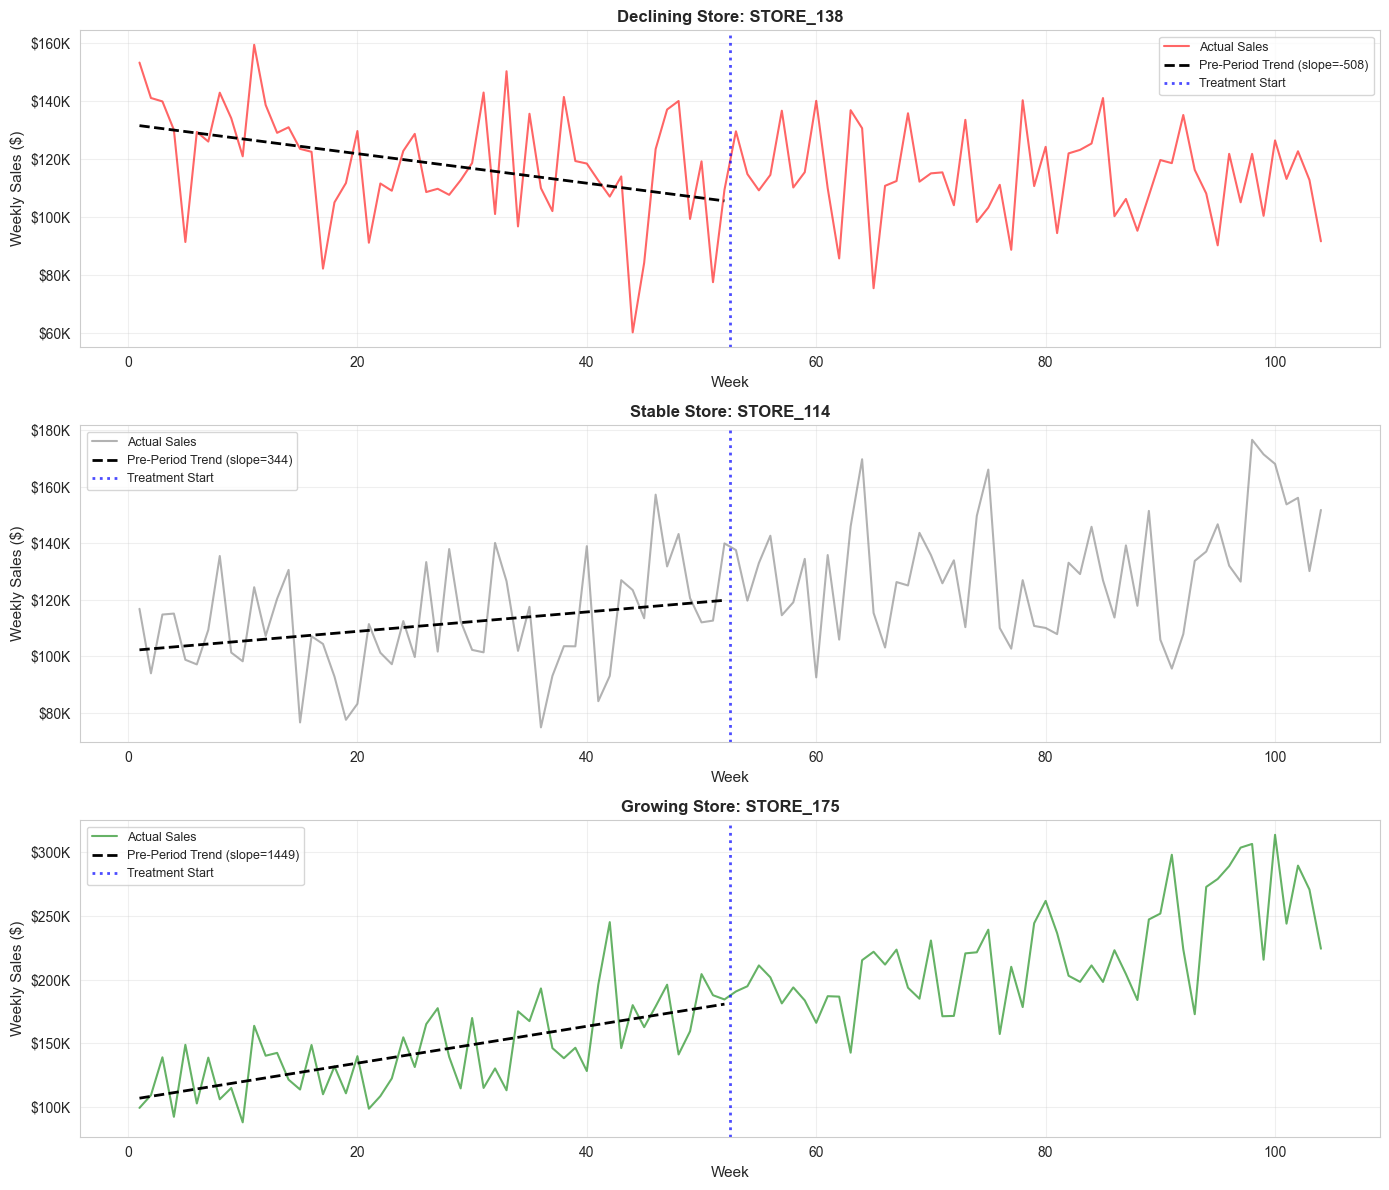

\nNote: The trend lines show the linear fit to pre-period data only.


In [13]:
# Plot time series for example stores
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

example_stores = [
    (declining_store, 'Declining Store', 'red'),
    (stable_store, 'Stable Store', 'gray'),
    (growing_store, 'Growing Store', 'green')
]

for idx, (store, label, color) in enumerate(example_stores):
    ax = axes[idx]
    
    # Get full time series for this store
    store_data = df[df['store_id'] == store].sort_values('week')
    
    # Get pre-period data and slope
    pre_data = store_data[store_data['week'] < TREATMENT_START_WEEK]
    slope = features_df[features_df['store_id'] == store]['pre_slope'].values[0]
    avg_sales = features_df[features_df['store_id'] == store]['pre_avg_sales'].values[0]
    
    # Plot actual sales
    ax.plot(store_data['week'], store_data['sales'], 
            color=color, alpha=0.6, linewidth=1.5, label='Actual Sales')
    
    # Add trend line for pre-period
    weeks_pre = pre_data['week'].values
    trend_line = slope * weeks_pre + (avg_sales - slope * weeks_pre.mean())
    ax.plot(weeks_pre, trend_line, 
            color='black', linestyle='--', linewidth=2, label=f'Pre-Period Trend (slope={slope:.0f})')
    
    # Mark treatment start
    ax.axvline(x=TREATMENT_START_WEEK - 0.5, color='blue', linestyle=':', 
               linewidth=2, alpha=0.7, label='Treatment Start')
    
    # Formatting
    ax.set_xlabel('Week', fontsize=11)
    ax.set_ylabel('Weekly Sales ($)', fontsize=11)
    ax.set_title(f'{label}: {store}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

print("\\nNote: The trend lines show the linear fit to pre-period data only.")

In [ ]:
# Plot multiple examples in a grid
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

store_groups = [
    (declining_stores, 'Declining Stores', 'red'),
    (stable_stores, 'Stable Stores', 'gray'),
    (growing_stores, 'Growing Stores', 'green')
]

for row_idx, (stores, group_label, color) in enumerate(store_groups):
    for col_idx, store in enumerate(stores):
        ax = axes[row_idx, col_idx]
        
        # Get data
        store_data = df[df['store_id'] == store].sort_values('week')
        pre_data = store_data[store_data['week'] < TREATMENT_START_WEEK]
        
        slope = features_df[features_df['store_id'] == store]['pre_slope'].values[0]
        avg_sales = features_df[features_df['store_id'] == store]['pre_avg_sales'].values[0]
        
        # Plot
        ax.plot(pre_data['week'], pre_data['sales'], 
                color=color, alpha=0.5, linewidth=1, marker='o', markersize=2)
        
        # Trend line
        weeks = pre_data['week'].values
        trend = slope * weeks + (avg_sales - slope * weeks.mean())
        ax.plot(weeks, trend, color='black', linestyle='--', linewidth=1.5)
        
        # Formatting
        if col_idx == 0:
            ax.set_ylabel('Sales ($)', fontsize=9)
        if row_idx == 2:
            ax.set_xlabel('Week', fontsize=9)
        
        ax.set_title(f'{store}\\nSlope: {slope:.0f} $/wk', fontsize=9)
        ax.grid(True, alpha=0.2)
        ax.tick_params(labelsize=8)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
        
        # Add group label on left
        if col_idx == 0:
            ax.text(-0.35, 0.5, group_label, transform=ax.transAxes, 
                   fontsize=11, fontweight='bold', rotation=90, 
                   verticalalignment='center')

plt.suptitle('Pre-Period Sales Trajectories by Growth Pattern', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [11]:
# Save the features table
output_path = '../data/store_preperiod_features.csv'
features_df.to_csv(output_path, index=False)

print(f"Saved pre-period features to: {output_path}")
print(f"\nFeatures table shape: {features_df.shape}")
print(f"\nColumns:")
for col in features_df.columns:
    print(f"  - {col}")

print("\n✓ Pre-period feature engineering complete!")

Saved pre-period features to: ../data/store_preperiod_features.csv

Features table shape: (200, 6)

Columns:
  - store_id
  - pre_slope
  - pre_avg_sales
  - pre_sales_std
  - pre_cv
  - treatment

✓ Pre-period feature engineering complete!
